In [1]:
# 📦 Imports and Configuration

import os
import json
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [3]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# 📁 src/metrics/regression_metrics.py
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [5]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Train MLP model with specified hyperparameters and seed
# ➤ Includes data loading, train-test split, early stopping, and evaluation
# ➤ Returns run_id and evaluation metrics on hold-out set


def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam", seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔀 Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # 📊 Plot distribution of target in train and test
    plt.figure(figsize=(8, 4))
    plt.hist(y_train.values, bins=30, alpha=0.6, label="Train", color='blue')
    plt.hist(y_test.values, bins=30, alpha=0.6, label="Test", color='orange')
    plt.title(f"🎯 Target Distribution (seed={seed})")
    plt.xlabel("Mean target value")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 🧪 Проверка на пересечение train и test
    intersection = set(X_train.index).intersection(set(X_test.index))
    if intersection:
        print(f"⚠️ Warning: Found {len(intersection)} overlapping samples in train and test!")
    else:
        print("✅ Train and test are properly separated (no overlap).")



    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # ----------------------------
    # Model creation
    # ----------------------------
    model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    early_stopping_patience = 20
    best_loss = float("inf")
    patience_counter = 0
    train_loss_history = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_loss_history.append(current_loss)

        log_interval = max(1, epochs // 10)
        if (epoch + 1) % log_interval == 0 or (epoch + 1) == epochs:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}")

        # Early Stopping
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
            best_weights = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    run_id = f"run_seed_{seed}"

    model.load_state_dict(best_weights)
    weights_registry[run_id] = best_weights


    # ----------------------------
    # Evaluate
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        metrics = evaluate_regression(y_test_tensor, y_pred)

    print(f"\n📊 Metrics:\n{metrics}")
    return run_id, metrics


First model configuration
config_mlp_128h_6e-03lr

In [6]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working/config_mlp_128h_4e-03lr"
config_path = '/kaggle/input/wind-fluctuation-prediction-final-model/config_mlp_128h_4e-03lr_ex.json'

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001"

In [7]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results



# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
# config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'
# 🏷 Get config filename (without extension) to use as config_name
config_filename = os.path.basename(config_path)
config_name = os.path.splitext(config_filename)[0]


# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 128, 'output_dim': 1, 'lr': 0.004, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /kaggle/working/config_mlp_128h_4e-03lr
📁 arch_label: mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 10 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


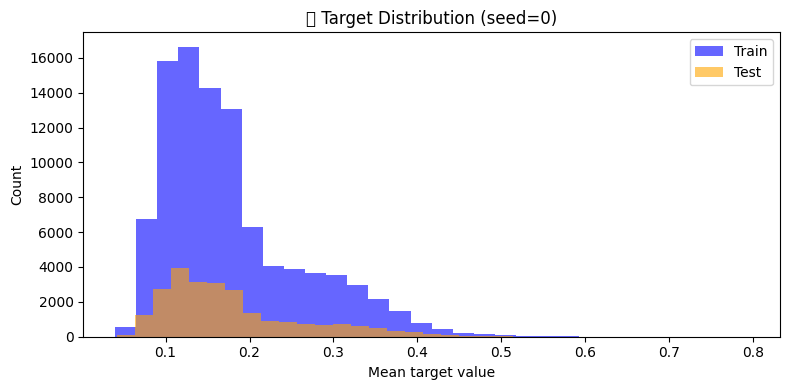

✅ Train and test are properly separated (no overlap).


Epochs:  27%|██▋       | 27/100 [00:00<00:01, 55.36it/s]

Epoch [10/100], Loss: 0.2115
Epoch [20/100], Loss: 0.0902
Epoch [30/100], Loss: 0.0218


Epochs:  58%|█████▊    | 58/100 [00:00<00:00, 99.35it/s]

Epoch [40/100], Loss: 0.0076
Epoch [50/100], Loss: 0.0066
Epoch [60/100], Loss: 0.0072
Epoch [70/100], Loss: 0.0067


Epochs: 100%|██████████| 100/100 [00:01<00:00, 86.02it/s]


Epoch [80/100], Loss: 0.0062
Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006070329, 'MAE': 0.058873367, 'R2': 0.12279583767419944}

🔁 Run 2 / 10 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


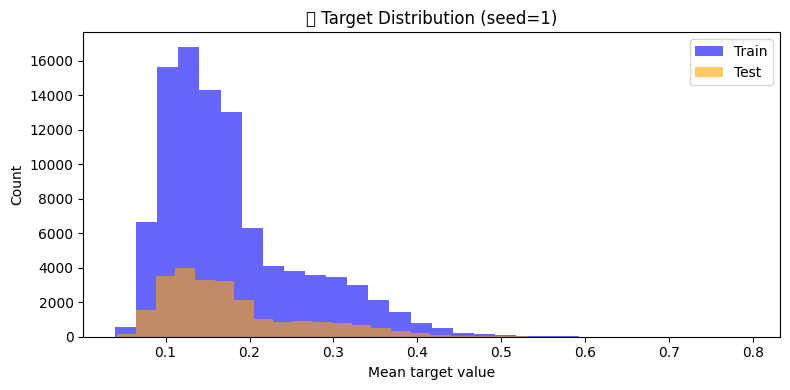

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 164.45it/s]

Epoch [10/100], Loss: 0.3450
Epoch [20/100], Loss: 0.1717
Epoch [30/100], Loss: 0.0647


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 160.95it/s]

Epoch [40/100], Loss: 0.0279


Epochs:  67%|██████▋   | 67/100 [00:00<00:00, 159.29it/s]

Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0094
Epoch [70/100], Loss: 0.0073
Epoch [80/100], Loss: 0.0065


Epochs: 100%|██████████| 100/100 [00:00<00:00, 159.16it/s]

Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.0063578556, 'MAE': 0.06019372, 'R2': 0.08696803180020629}

🔁 Run 3 / 10 (seed = 2)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


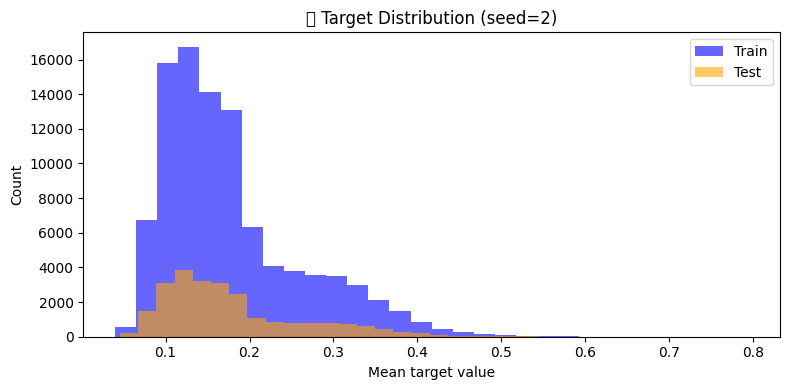

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 164.44it/s]

Epoch [10/100], Loss: 0.3204
Epoch [20/100], Loss: 0.1521
Epoch [30/100], Loss: 0.0544


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 160.82it/s]

Epoch [40/100], Loss: 0.0228


Epochs:  67%|██████▋   | 67/100 [00:00<00:00, 159.15it/s]

Epoch [50/100], Loss: 0.0111
Epoch [60/100], Loss: 0.0072
Epoch [70/100], Loss: 0.0063
Epoch [80/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:00<00:00, 158.97it/s]

Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.006268528, 'MAE': 0.060200907, 'R2': 0.09998071969759514}

🔁 Run 4 / 10 (seed = 3)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


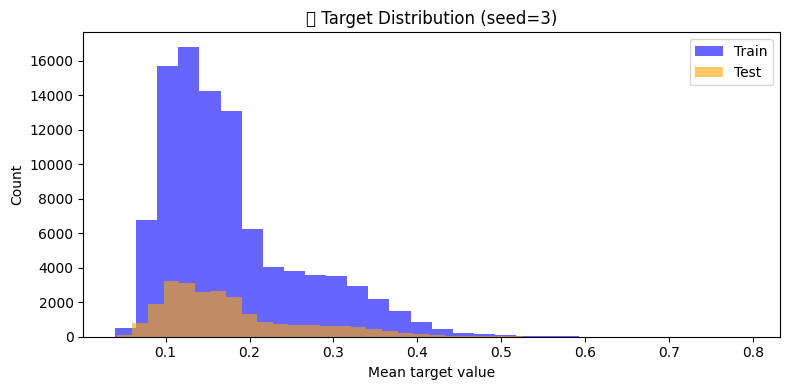

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 164.24it/s]

Epoch [10/100], Loss: 0.2582
Epoch [20/100], Loss: 0.1391
Epoch [30/100], Loss: 0.0505


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 160.32it/s]

Epoch [40/100], Loss: 0.0218


Epochs:  67%|██████▋   | 67/100 [00:00<00:00, 159.16it/s]

Epoch [50/100], Loss: 0.0124
Epoch [60/100], Loss: 0.0090
Epoch [70/100], Loss: 0.0074
Epoch [80/100], Loss: 0.0067


Epochs: 100%|██████████| 100/100 [00:00<00:00, 158.88it/s]

Epoch [90/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.0062633716, 'MAE': 0.059928477, 'R2': 0.08690095727678115}

🔁 Run 5 / 10 (seed = 4)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


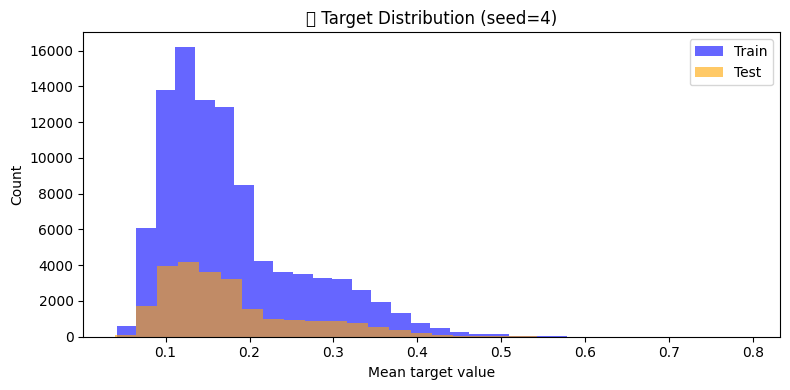

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 163.70it/s]

Epoch [10/100], Loss: 0.3236
Epoch [20/100], Loss: 0.1317
Epoch [30/100], Loss: 0.0415


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.93it/s]

Epoch [40/100], Loss: 0.0160


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 158.25it/s]

Epoch [50/100], Loss: 0.0083
Epoch [60/100], Loss: 0.0066
Epoch [70/100], Loss: 0.0066
Epoch [80/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 158.00it/s]

Epoch [90/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.0061586443, 'MAE': 0.06024469, 'R2': 0.10610384615316748}

🔁 Run 6 / 10 (seed = 5)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


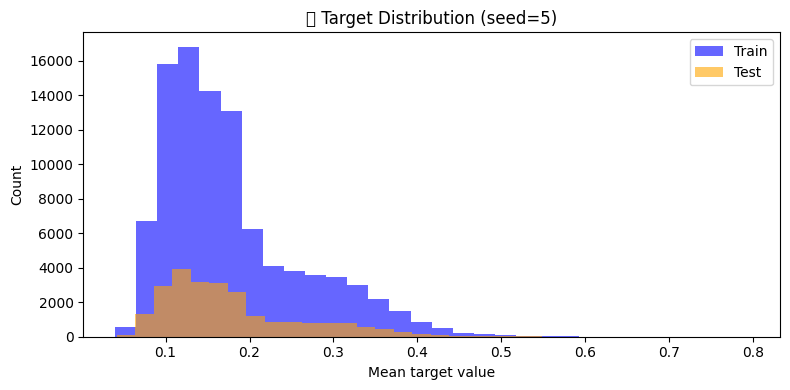

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 163.82it/s]

Epoch [10/100], Loss: 0.2558
Epoch [20/100], Loss: 0.1356
Epoch [30/100], Loss: 0.0531


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 160.74it/s]

Epoch [40/100], Loss: 0.0223


Epochs:  67%|██████▋   | 67/100 [00:00<00:00, 159.26it/s]

Epoch [50/100], Loss: 0.0107
Epoch [60/100], Loss: 0.0070
Epoch [70/100], Loss: 0.0066
Epoch [80/100], Loss: 0.0067


Epochs: 100%|██████████| 100/100 [00:00<00:00, 159.11it/s]

Epoch [90/100], Loss: 0.0065
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006354021, 'MAE': 0.060748897, 'R2': 0.09004648832447326}

🔁 Run 7 / 10 (seed = 6)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


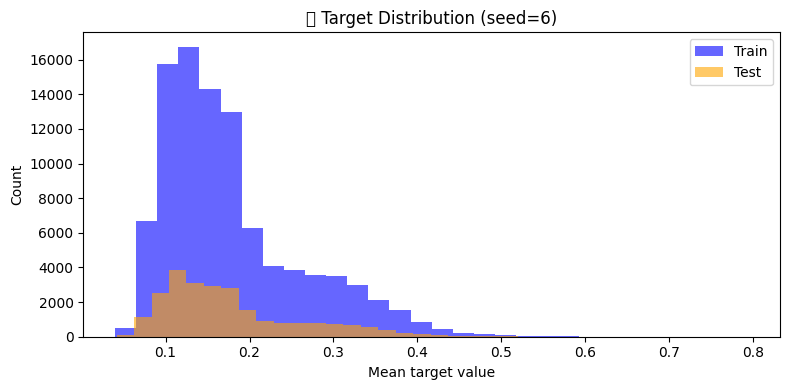

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 164.13it/s]

Epoch [10/100], Loss: 0.2583
Epoch [20/100], Loss: 0.1208
Epoch [30/100], Loss: 0.0362


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 160.14it/s]

Epoch [40/100], Loss: 0.0117


Epochs:  67%|██████▋   | 67/100 [00:00<00:00, 158.47it/s]

Epoch [50/100], Loss: 0.0067
Epoch [60/100], Loss: 0.0071
Epoch [70/100], Loss: 0.0071
Epoch [80/100], Loss: 0.0065


Epochs: 100%|██████████| 100/100 [00:00<00:00, 158.53it/s]

Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006291541, 'MAE': 0.05986277, 'R2': 0.08702780947545785}

🔁 Run 8 / 10 (seed = 7)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


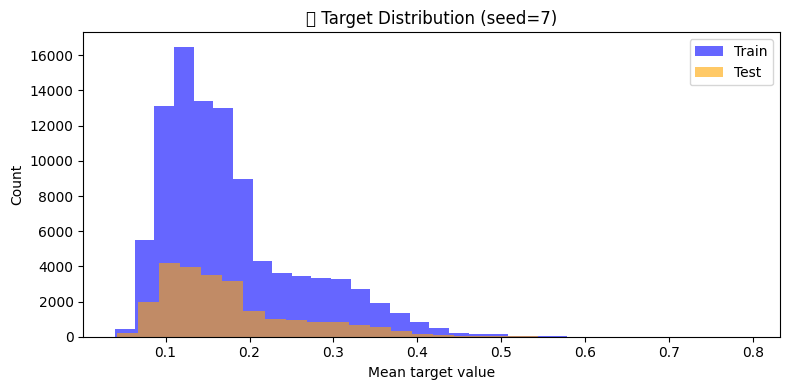

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 162.78it/s]

Epoch [10/100], Loss: 0.2858
Epoch [20/100], Loss: 0.1274
Epoch [30/100], Loss: 0.0426


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.47it/s]

Epoch [40/100], Loss: 0.0154


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.97it/s]

Epoch [50/100], Loss: 0.0075
Epoch [60/100], Loss: 0.0066
Epoch [70/100], Loss: 0.0069
Epoch [80/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.75it/s]

Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006246466, 'MAE': 0.06210759, 'R2': 0.08985072182972398}

🔁 Run 9 / 10 (seed = 8)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


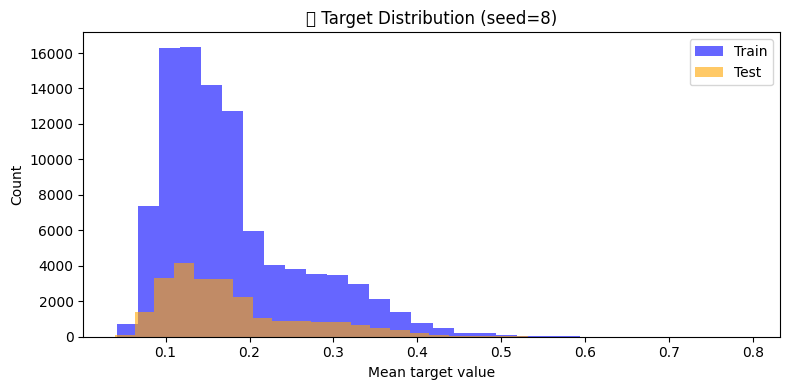

✅ Train and test are properly separated (no overlap).


Epochs:  27%|██▋       | 27/100 [00:00<00:00, 154.63it/s]

Epoch [10/100], Loss: 0.2777
Epoch [20/100], Loss: 0.1063
⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.041242924, 'MAE': 0.18790695, 'R2': -4.905409893805983}

🔁 Run 10 / 10 (seed = 9)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


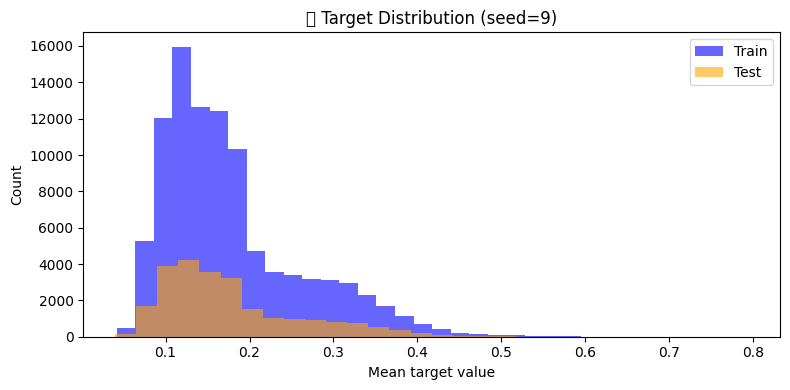

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 163.29it/s]

Epoch [10/100], Loss: 0.2242
Epoch [20/100], Loss: 0.0902
Epoch [30/100], Loss: 0.0238


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.81it/s]

Epoch [40/100], Loss: 0.0083


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 158.20it/s]

Epoch [50/100], Loss: 0.0066
Epoch [60/100], Loss: 0.0072
Epoch [70/100], Loss: 0.0068
Epoch [80/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.95it/s]

Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.0061287265, 'MAE': 0.05900295, 'R2': 0.1139218137935677}
📁 Best weights saved to: /kaggle/working/config_mlp_128h_4e-03lr/best_model_weights_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_0 with R2 = 0.1228
   R2   = 0.1228
   MAE  = 0.0589
   MSE  = 0.006070


In [8]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 10  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Ensure save directory exists
os.makedirs(SAVE_ROOT, exist_ok=True)

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save best run's metrics
best_metrics = {k: float(v) for k, v in best_metrics.items()}
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


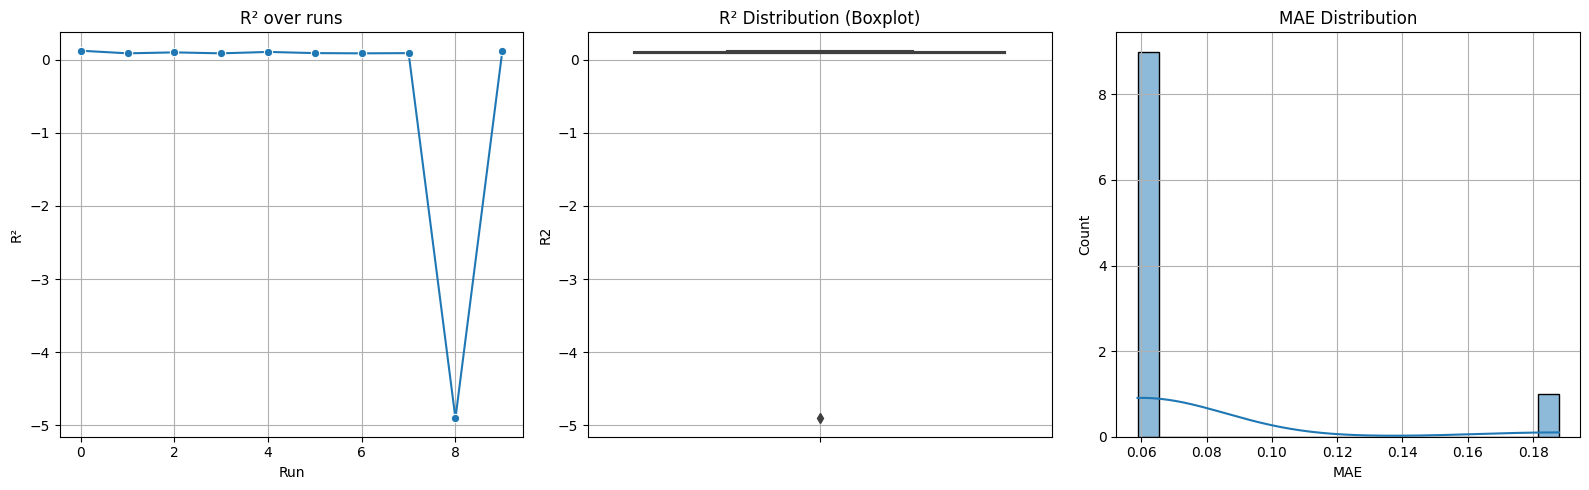

📈 Stability analysis complete:
{
    "R2_mean": -0.4022,
    "R2_std": 1.5823,
    "MAE_mean": 0.0729,
    "MAE_std": 0.0404,
    "MSE_mean": 0.009738,
    "MSE_std": 0.01107,
    "runs": 10
}
📁 Saved metrics: /kaggle/working/config_mlp_128h_4e-03lr/stability_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /kaggle/working/config_mlp_128h_4e-03lr/stability_plot_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.png


In [9]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


Second model configuration
config_mlp_128h_6e-03lr

In [10]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working/config_mlp_128h_6e-03lr"
config_path = '/kaggle/input/wind-fluctuation-prediction-final-model/config_mlp_128h_6e-03lr_ex.json'

In [11]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
# config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'
# 🏷 Get config filename (without extension) to use as config_name
config_filename = os.path.basename(config_path)
config_name = os.path.splitext(config_filename)[0]

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 128, 'output_dim': 1, 'lr': 0.006, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /kaggle/working/config_mlp_128h_6e-03lr
📁 arch_label: mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 10 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


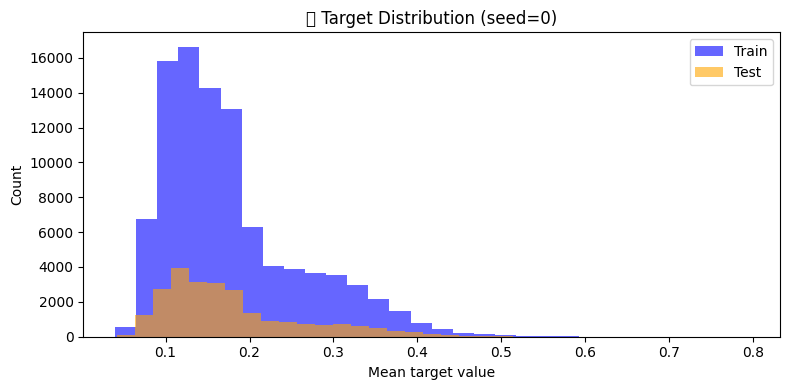

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 162.88it/s]

Epoch [10/100], Loss: 0.3351
Epoch [20/100], Loss: 0.1655
Epoch [30/100], Loss: 0.0302


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.39it/s]

Epoch [40/100], Loss: 0.0073


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.45it/s]

Epoch [50/100], Loss: 0.0131
Epoch [60/100], Loss: 0.0081
Epoch [70/100], Loss: 0.0066
Epoch [80/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.63it/s]

Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.0062195426, 'MAE': 0.06081726, 'R2': 0.10123338108617441}

🔁 Run 2 / 10 (seed = 1)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


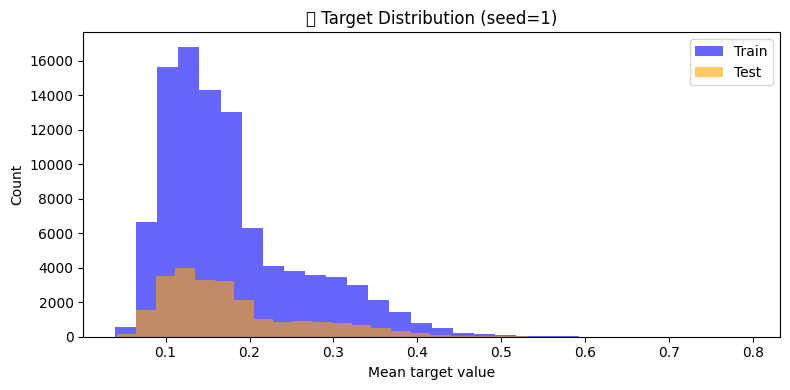

✅ Train and test are properly separated (no overlap).


Epochs:  27%|██▋       | 27/100 [00:00<00:00, 155.01it/s]

Epoch [10/100], Loss: 0.5407
Epoch [20/100], Loss: 0.2638
⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.105299056, 'MAE': 0.30717656, 'R2': -14.121671609223043}

🔁 Run 3 / 10 (seed = 2)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


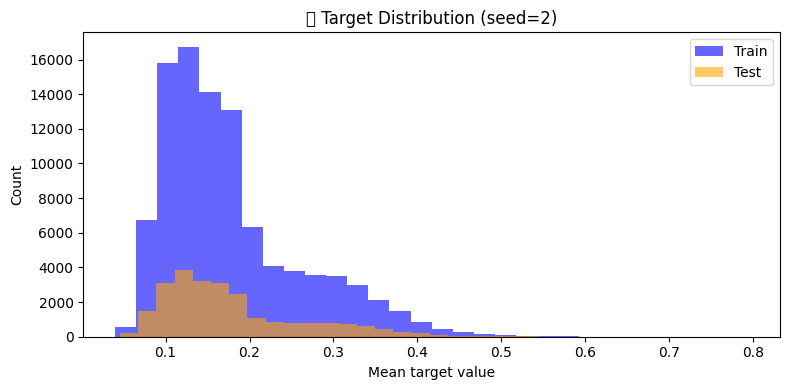

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 162.72it/s]

Epoch [10/100], Loss: 0.4594
Epoch [20/100], Loss: 0.2117
Epoch [30/100], Loss: 0.0818


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.17it/s]

Epoch [40/100], Loss: 0.0262


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.81it/s]

Epoch [50/100], Loss: 0.0082
Epoch [60/100], Loss: 0.0068
Epoch [70/100], Loss: 0.0075
Epoch [80/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.65it/s]

Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.0062511354, 'MAE': 0.06220886, 'R2': 0.10247780594731737}

🔁 Run 4 / 10 (seed = 3)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


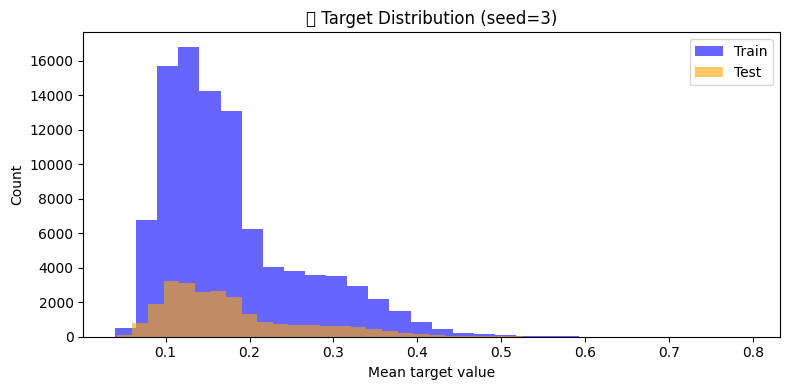

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 163.38it/s]

Epoch [10/100], Loss: 0.3949
Epoch [20/100], Loss: 0.1932
Epoch [30/100], Loss: 0.0889


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.27it/s]

Epoch [40/100], Loss: 0.0383


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.50it/s]

Epoch [50/100], Loss: 0.0138
Epoch [60/100], Loss: 0.0067
Epoch [70/100], Loss: 0.0069
Epoch [80/100], Loss: 0.0069


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.25it/s]

Epoch [90/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0064

📊 Metrics:
{'MSE': 0.0063088024, 'MAE': 0.06317922, 'R2': 0.08027801574876903}

🔁 Run 5 / 10 (seed = 4)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


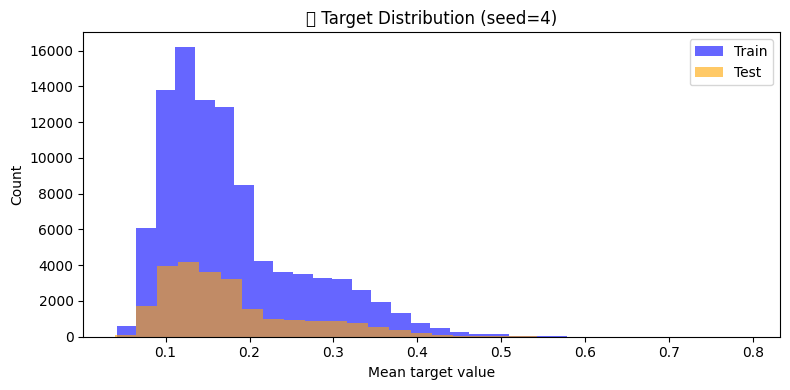

✅ Train and test are properly separated (no overlap).


Epochs:  27%|██▋       | 27/100 [00:00<00:00, 154.76it/s]

Epoch [10/100], Loss: 0.4290
Epoch [20/100], Loss: 0.2039
⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.08466486, 'MAE': 0.27533713, 'R2': -11.288676926873327}

🔁 Run 6 / 10 (seed = 5)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


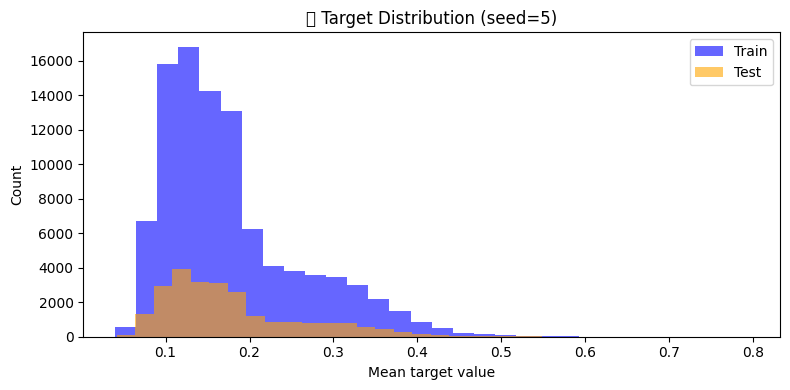

✅ Train and test are properly separated (no overlap).


Epochs:  27%|██▋       | 27/100 [00:00<00:00, 154.02it/s]

Epoch [10/100], Loss: 0.3893
Epoch [20/100], Loss: 0.2018
⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.083228804, 'MAE': 0.2718821, 'R2': -10.919120088442428}

🔁 Run 7 / 10 (seed = 6)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


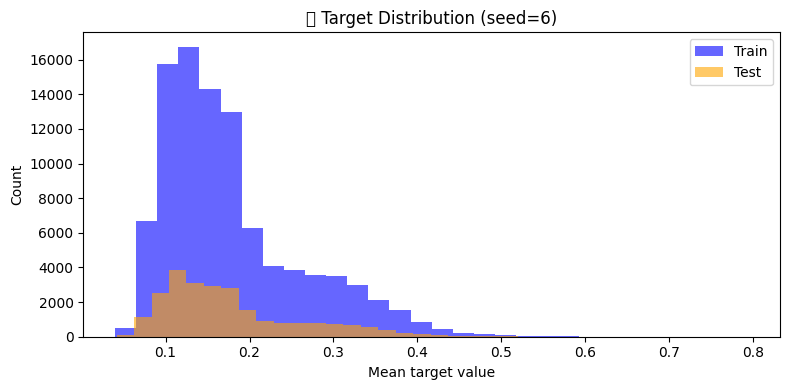

✅ Train and test are properly separated (no overlap).


Epochs:  27%|██▋       | 27/100 [00:00<00:00, 154.03it/s]

Epoch [10/100], Loss: 0.3762
Epoch [20/100], Loss: 0.1736
⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.063498646, 'MAE': 0.23498364, 'R2': -8.21435570646138}

🔁 Run 8 / 10 (seed = 7)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


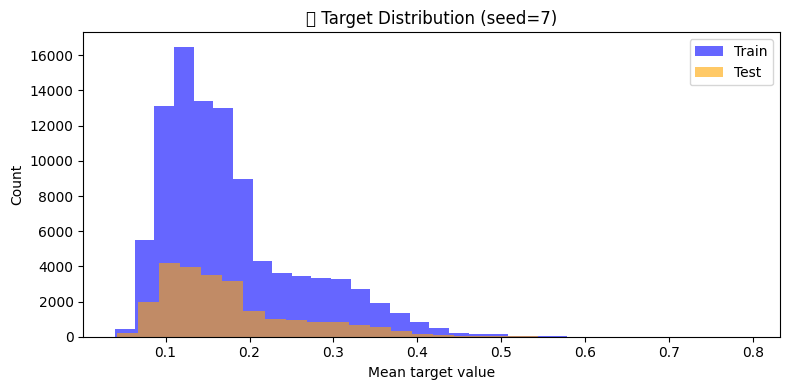

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 161.65it/s]

Epoch [10/100], Loss: 0.4092
Epoch [20/100], Loss: 0.1626
Epoch [30/100], Loss: 0.0300


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 158.38it/s]

Epoch [40/100], Loss: 0.0069


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.06it/s]

Epoch [50/100], Loss: 0.0119
Epoch [60/100], Loss: 0.0086
Epoch [70/100], Loss: 0.0065
Epoch [80/100], Loss: 0.0067


Epochs: 100%|██████████| 100/100 [00:00<00:00, 156.97it/s]

Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.0061800648, 'MAE': 0.059790887, 'R2': 0.09952583446755792}

🔁 Run 9 / 10 (seed = 8)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


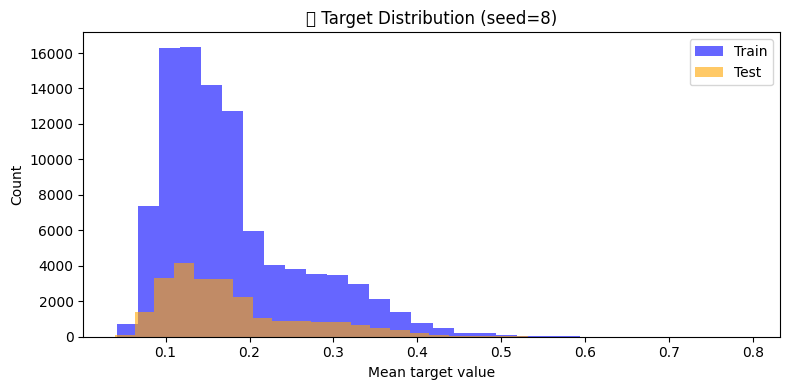

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 162.95it/s]

Epoch [10/100], Loss: 0.4303
Epoch [20/100], Loss: 0.1666
Epoch [30/100], Loss: 0.0278


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 159.37it/s]

Epoch [40/100], Loss: 0.0069


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.60it/s]

Epoch [50/100], Loss: 0.0126
Epoch [60/100], Loss: 0.0083
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.53it/s]

Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.0062874528, 'MAE': 0.061686635, 'R2': 0.09972470378452492}

🔁 Run 10 / 10 (seed = 9)


Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


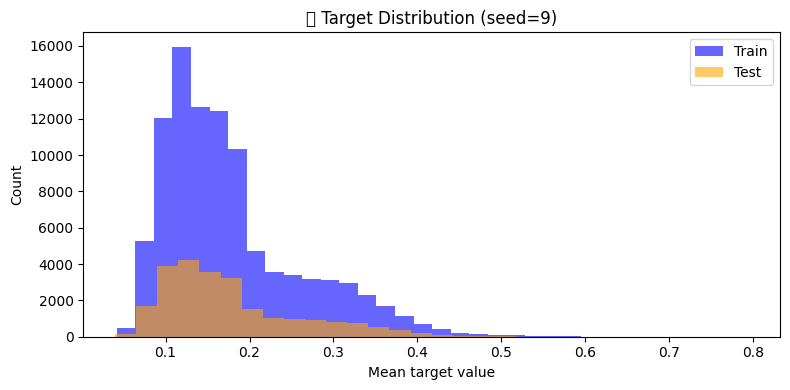

✅ Train and test are properly separated (no overlap).


Epochs:  17%|█▋        | 17/100 [00:00<00:00, 161.38it/s]

Epoch [10/100], Loss: 0.3451
Epoch [20/100], Loss: 0.1697
Epoch [30/100], Loss: 0.0359


Epochs:  34%|███▍      | 34/100 [00:00<00:00, 158.63it/s]

Epoch [40/100], Loss: 0.0066


Epochs:  66%|██████▌   | 66/100 [00:00<00:00, 157.23it/s]

Epoch [50/100], Loss: 0.0102
Epoch [60/100], Loss: 0.0089
Epoch [70/100], Loss: 0.0063
Epoch [80/100], Loss: 0.0065


Epochs: 100%|██████████| 100/100 [00:00<00:00, 157.20it/s]

Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006150738, 'MAE': 0.061081823, 'R2': 0.11073950904754881}
📁 Best weights saved to: /kaggle/working/config_mlp_128h_6e-03lr/best_model_weights_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_9 with R2 = 0.1107
   R2   = 0.1107
   MAE  = 0.0611
   MSE  = 0.006151


In [12]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 10  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Ensure save directory exists
os.makedirs(SAVE_ROOT, exist_ok=True)

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save best run's metrics
best_metrics = {k: float(v) for k, v in best_metrics.items()}
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


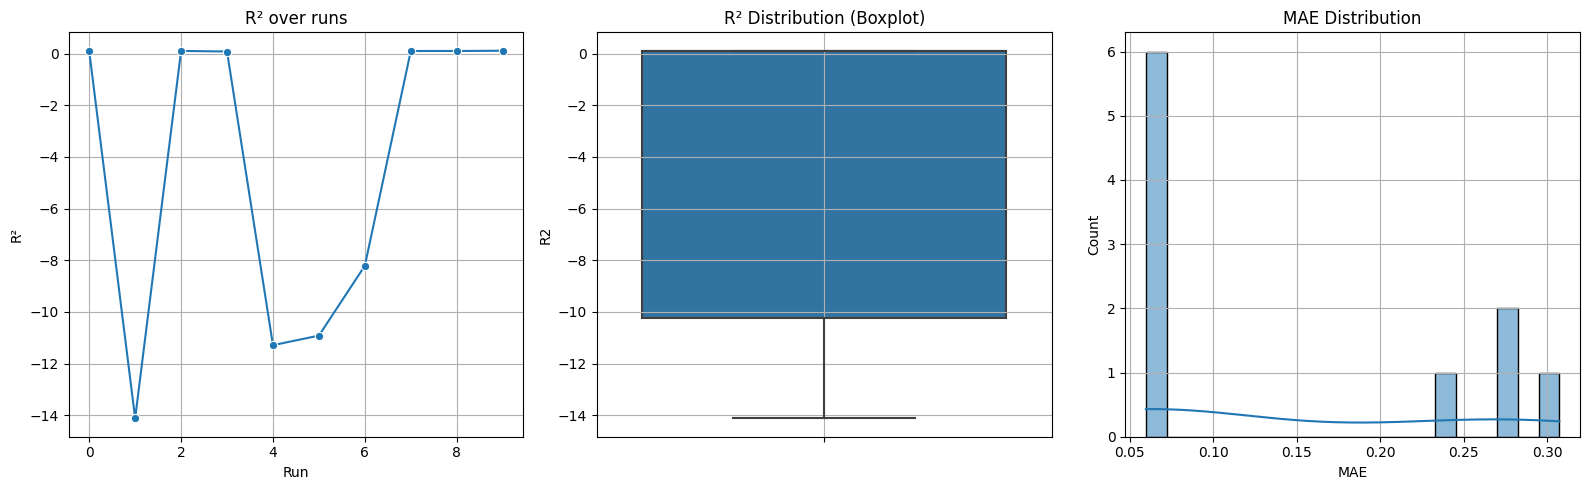

📈 Stability analysis complete:
{
    "R2_mean": -4.395,
    "R2_std": 5.9671,
    "MAE_mean": 0.1458,
    "MAE_std": 0.1102,
    "MSE_mean": 0.037409,
    "MSE_std": 0.041438,
    "runs": 10
}
📁 Saved metrics: /kaggle/working/config_mlp_128h_6e-03lr/stability_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /kaggle/working/config_mlp_128h_6e-03lr/stability_plot_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.png


In [13]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


Third model configuration
config_mlp_64h_8e-03lr

In [14]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working/config_mlp_64h_8e-03lr"
config_path = '/kaggle/input/wind-fluctuation-prediction-final-model/config_mlp_64h_8e-03lr_ex.json'

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001"

In [15]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
# config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'
# 🏷 Get config filename (without extension) to use as config_name
config_filename = os.path.basename(config_path)
config_name = os.path.splitext(config_filename)[0]

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 64, 'output_dim': 1, 'lr': 0.008, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /kaggle/working/config_mlp_64h_8e-03lr
📁 arch_label: mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 10 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


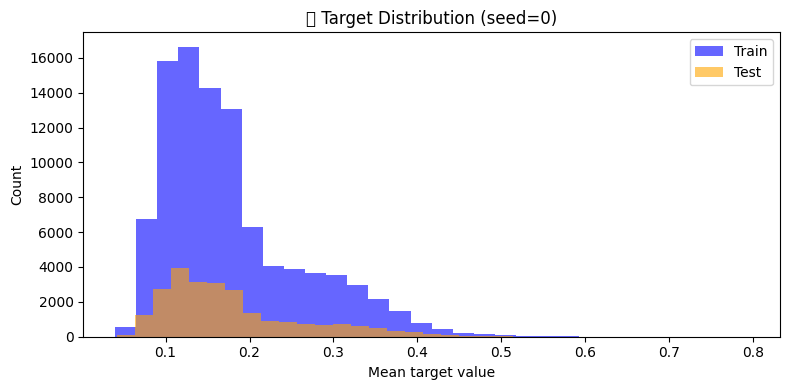

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 274.59it/s]

Epoch [10/100], Loss: 0.1557
Epoch [20/100], Loss: 0.0319
Epoch [30/100], Loss: 0.0071
Epoch [40/100], Loss: 0.0108
Epoch [50/100], Loss: 0.0080


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 271.89it/s]

Epoch [60/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:00<00:00, 271.01it/s]


Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0061
Epoch [90/100], Loss: 0.0061
Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.006050573, 'MAE': 0.059631057, 'R2': 0.12565061879929396}

🔁 Run 2 / 10 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


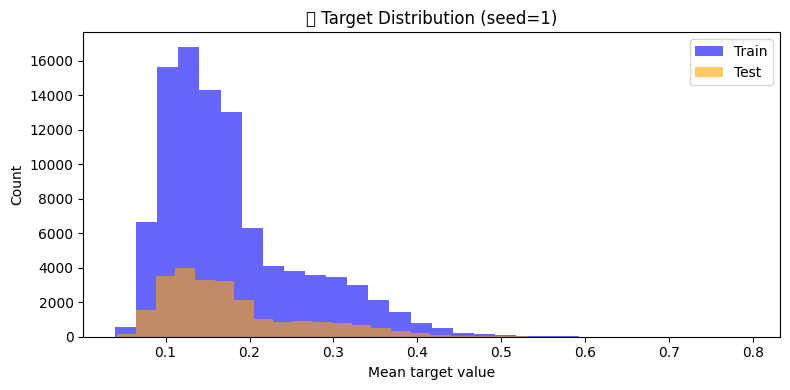

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 274.75it/s]

Epoch [10/100], Loss: 0.1597
Epoch [20/100], Loss: 0.0649
Epoch [30/100], Loss: 0.0224
Epoch [40/100], Loss: 0.0107
Epoch [50/100], Loss: 0.0072


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 271.80it/s]

Epoch [60/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:00<00:00, 270.91it/s]


Epoch [70/100], Loss: 0.0063
Epoch [80/100], Loss: 0.0063
Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006116101, 'MAE': 0.059999328, 'R2': 0.12168563018457901}

🔁 Run 3 / 10 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


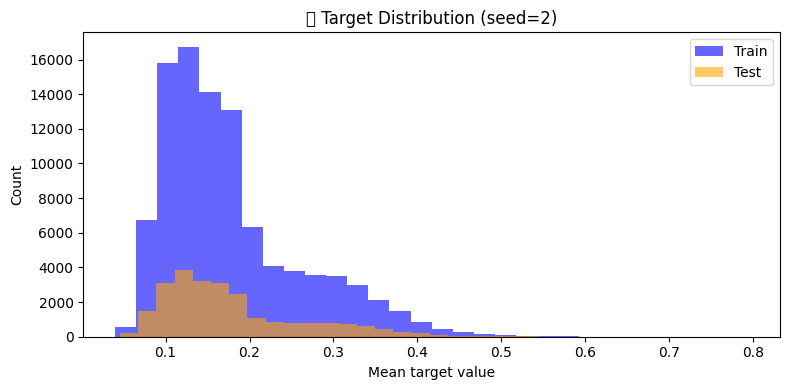

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 276.02it/s]

Epoch [10/100], Loss: 0.0986
Epoch [20/100], Loss: 0.0221
Epoch [30/100], Loss: 0.0081
Epoch [40/100], Loss: 0.0107
Epoch [50/100], Loss: 0.0067


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 272.64it/s]

Epoch [60/100], Loss: 0.0065


Epochs: 100%|██████████| 100/100 [00:00<00:00, 271.36it/s]


Epoch [70/100], Loss: 0.0062
Epoch [80/100], Loss: 0.0061
Epoch [90/100], Loss: 0.0060
Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.0060471334, 'MAE': 0.059994623, 'R2': 0.13176806610049419}

🔁 Run 4 / 10 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


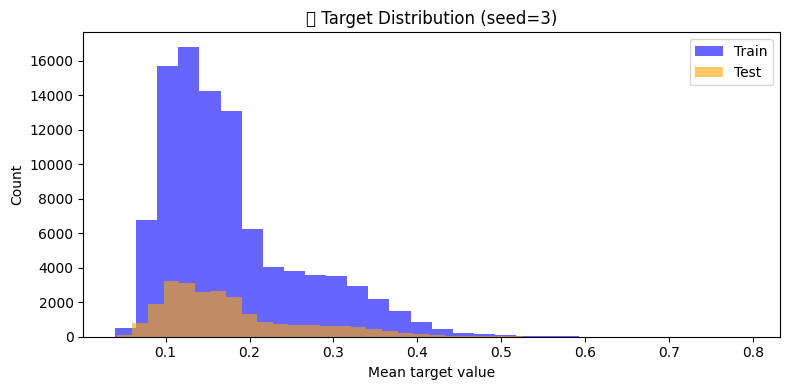

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 275.70it/s]

Epoch [10/100], Loss: 0.1791
Epoch [20/100], Loss: 0.0894
Epoch [30/100], Loss: 0.0240
Epoch [40/100], Loss: 0.0080
Epoch [50/100], Loss: 0.0067


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 272.68it/s]

Epoch [60/100], Loss: 0.0073


Epochs: 100%|██████████| 100/100 [00:00<00:00, 271.84it/s]


Epoch [70/100], Loss: 0.0067
Epoch [80/100], Loss: 0.0063
Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006075088, 'MAE': 0.05995844, 'R2': 0.11434972280604672}

🔁 Run 5 / 10 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


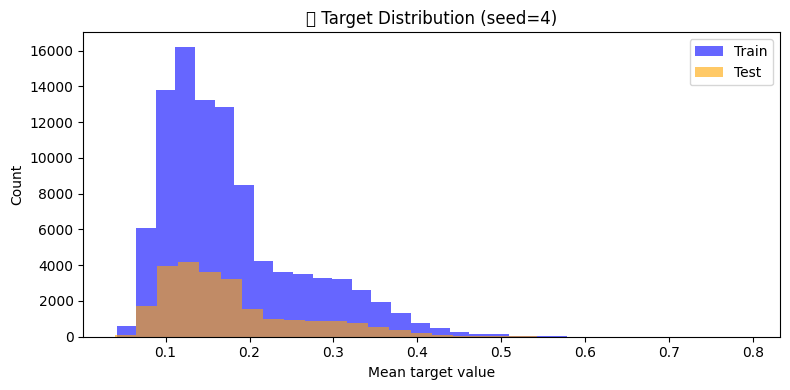

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 275.05it/s]

Epoch [10/100], Loss: 0.1392
Epoch [20/100], Loss: 0.0170
Epoch [30/100], Loss: 0.0101
Epoch [40/100], Loss: 0.0116
Epoch [50/100], Loss: 0.0068


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 271.69it/s]

Epoch [60/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 270.13it/s]


Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0062
Epoch [90/100], Loss: 0.0061
Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.005924682, 'MAE': 0.058441237, 'R2': 0.1400622069102314}

🔁 Run 6 / 10 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


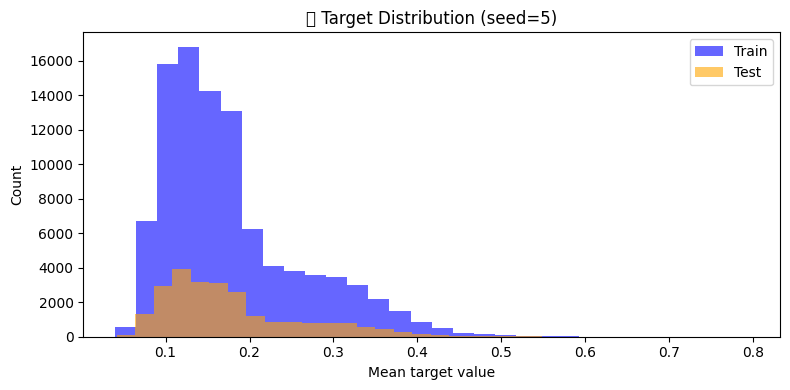

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 273.99it/s]

Epoch [10/100], Loss: 0.1114
Epoch [20/100], Loss: 0.0386
Epoch [30/100], Loss: 0.0079
Epoch [40/100], Loss: 0.0080
Epoch [50/100], Loss: 0.0083


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 271.33it/s]

Epoch [60/100], Loss: 0.0066


Epochs: 100%|██████████| 100/100 [00:00<00:00, 269.99it/s]


Epoch [70/100], Loss: 0.0065
Epoch [80/100], Loss: 0.0063
Epoch [90/100], Loss: 0.0063
Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.006205874, 'MAE': 0.060265046, 'R2': 0.11126255670801821}

🔁 Run 7 / 10 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


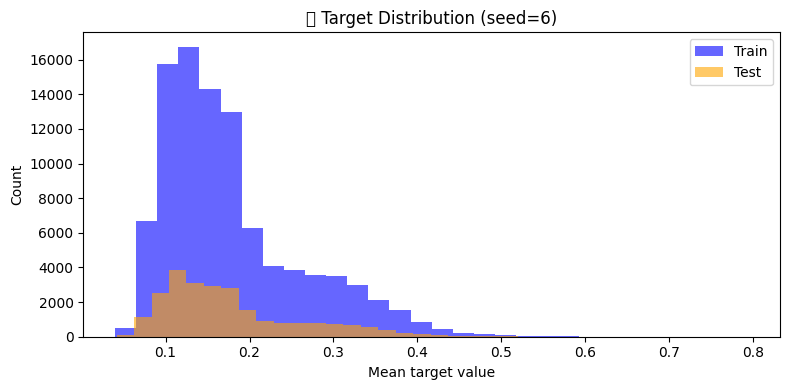

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 274.50it/s]

Epoch [10/100], Loss: 0.1764
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0133
Epoch [40/100], Loss: 0.0122
Epoch [50/100], Loss: 0.0064


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 270.35it/s]

Epoch [60/100], Loss: 0.0070


Epochs: 100%|██████████| 100/100 [00:00<00:00, 269.20it/s]


Epoch [70/100], Loss: 0.0062
Epoch [80/100], Loss: 0.0063
Epoch [90/100], Loss: 0.0061
Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.0060246275, 'MAE': 0.05894529, 'R2': 0.12575993754446413}

🔁 Run 8 / 10 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


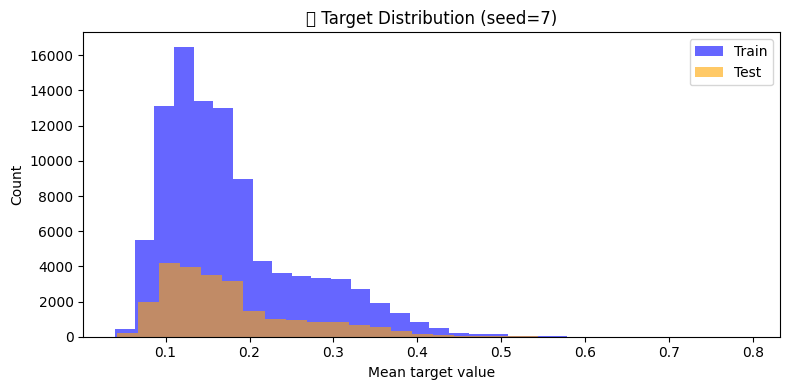

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 274.98it/s]

Epoch [10/100], Loss: 0.0882
Epoch [20/100], Loss: 0.0592
Epoch [30/100], Loss: 0.0127
Epoch [40/100], Loss: 0.0066
Epoch [50/100], Loss: 0.0080


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 271.35it/s]

Epoch [60/100], Loss: 0.0071


Epochs: 100%|██████████| 100/100 [00:00<00:00, 270.23it/s]


Epoch [70/100], Loss: 0.0063
Epoch [80/100], Loss: 0.0063
Epoch [90/100], Loss: 0.0062
Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006040771, 'MAE': 0.06083013, 'R2': 0.1198218378825534}

🔁 Run 9 / 10 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


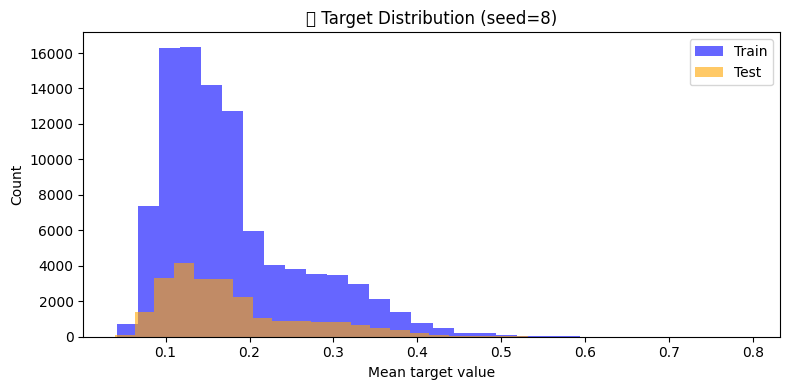

✅ Train and test are properly separated (no overlap).


Epochs:  28%|██▊       | 28/100 [00:00<00:00, 275.09it/s]

Epoch [10/100], Loss: 0.2059
Epoch [20/100], Loss: 0.0781
Epoch [30/100], Loss: 0.0201
Epoch [40/100], Loss: 0.0075
Epoch [50/100], Loss: 0.0069


Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 272.16it/s]

Epoch [60/100], Loss: 0.0074


Epochs: 100%|██████████| 100/100 [00:00<00:00, 270.94it/s]


Epoch [70/100], Loss: 0.0067
Epoch [80/100], Loss: 0.0064
Epoch [90/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006372488, 'MAE': 0.06125268, 'R2': 0.08754886506911586}

🔁 Run 10 / 10 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_19/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


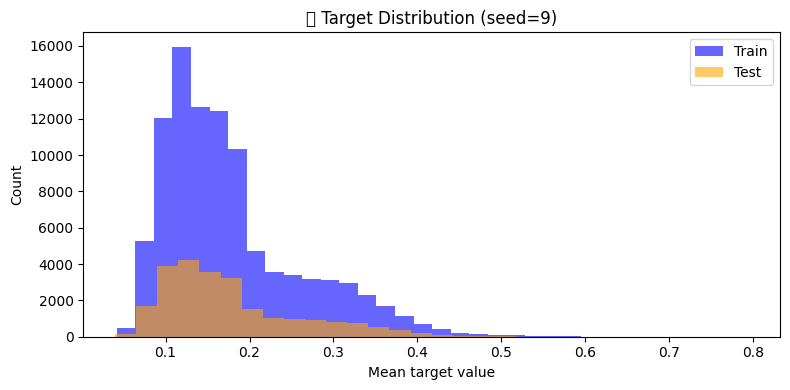

✅ Train and test are properly separated (no overlap).


Epochs:  42%|████▏     | 42/100 [00:00<00:00, 263.31it/s]

Epoch [10/100], Loss: 0.1262
Epoch [20/100], Loss: 0.0432
Epoch [30/100], Loss: 0.0109
Epoch [40/100], Loss: 0.0070
⏹️ Early stopping at epoch 43

📊 Metrics:
{'MSE': 0.009978394, 'MAE': 0.08696669, 'R2': -0.442654820145459}
📁 Best weights saved to: /kaggle/working/config_mlp_64h_8e-03lr/best_model_weights_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_4 with R2 = 0.1401
   R2   = 0.1401
   MAE  = 0.0584
   MSE  = 0.005925


In [16]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 10  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Ensure save directory exists
os.makedirs(SAVE_ROOT, exist_ok=True)

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save best run's metrics
best_metrics = {k: float(v) for k, v in best_metrics.items()}
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


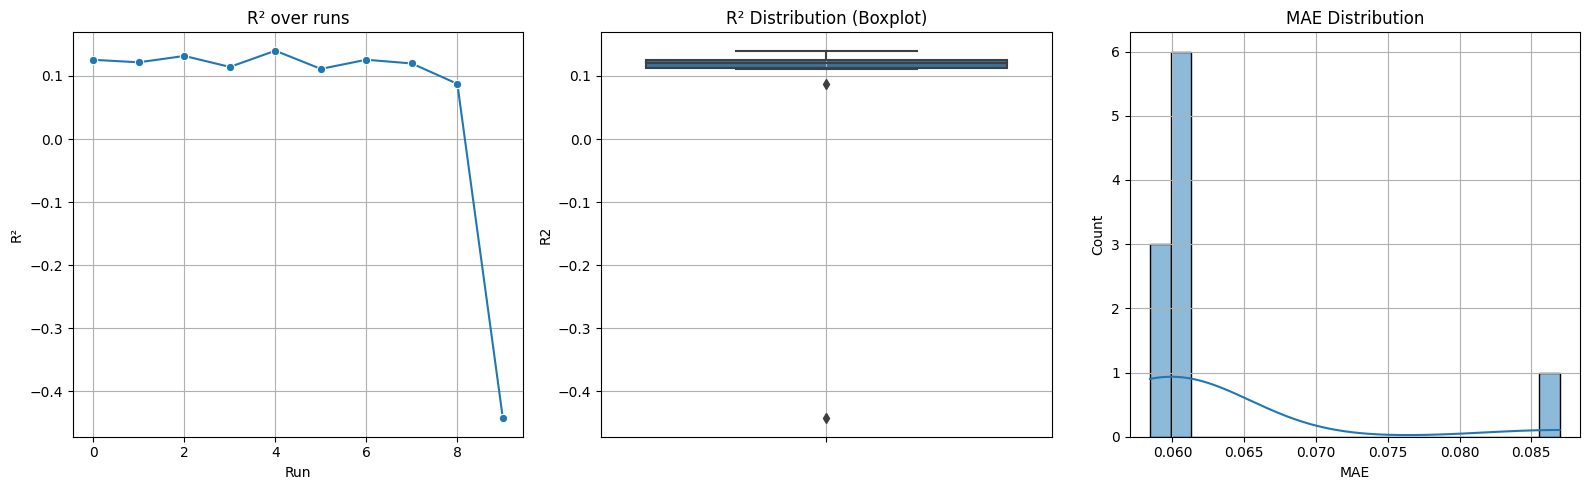

📈 Stability analysis complete:
{
    "R2_mean": 0.0635,
    "R2_std": 0.1784,
    "MAE_mean": 0.0626,
    "MAE_std": 0.0086,
    "MSE_mean": 0.006484,
    "MSE_std": 0.001234,
    "runs": 10
}
📁 Saved metrics: /kaggle/working/config_mlp_64h_8e-03lr/stability_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /kaggle/working/config_mlp_64h_8e-03lr/stability_plot_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.png


In [17]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
